In [126]:
%%writefile ./pipelines/mnist/preprocess.py
"""Prepare Mnist Dataset"""
import argparse
import logging
import pathlib
import os
from torchvision import transforms
from torchvision.datasets import MNIST


logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


if __name__ == "__main__":
    logger.debug("Starting preprocessing.")
    parser = argparse.ArgumentParser()
    parser.add_argument("--arg", type=str, required=False)
    args = parser.parse_args()
    arg = args.arg
    
    logger.debug("Defining transforms")
    mnist_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (1.0,))
    ])
    
    base_dir = "/opt/ml/processing"

    logger.debug("Downloading and applying transforms")
    MNIST(f'{base_dir}/train', transform=mnist_transform, train=True, download=True)
    MNIST(f'{base_dir}/test', transform=mnist_transform, train=False, download=True)

Overwriting ./pipelines/mnist/preprocess.py


In [127]:
%%writefile ./pipelines/mnist/code/model.py
"""Pytorch Mnist Model"""
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Overwriting ./pipelines/mnist/code/model.py


In [128]:
%%writefile ./pipelines/mnist/code/dataloader.py
"""Data Loader"""
import logging
import sys

import torch
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def get_train_data_loader(batch_size, training_dir, is_distributed, **kwargs):
    logger.info("Get train data loader", training_dir)

    mnist_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (1.0,))
    ])
    dataset = MNIST(training_dir, transform=mnist_transform, train=True)
#     dataset = MNIST("./data", transform=mnist_transform, train=True, download=True)
    train_sampler = (
        torch.utils.data.distributed.DistributedSampler(dataset) if is_distributed else None
    )
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train_sampler is None,
        sampler=train_sampler,
        **kwargs
    )


def get_test_data_loader(test_batch_size, test_dir, **kwargs):
    logger.info("Get test data loader", test_dir)
    mnist_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (1.0,))
    ])
    dataset = MNIST(test_dir, transform=mnist_transform, train=False)
#     dataset = MNIST("./data", transform=mnist_transform, train=False, download=True)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=test_batch_size,
        shuffle=True,
        **kwargs
    )


Overwriting ./pipelines/mnist/code/dataloader.py


In [129]:
%%writefile ./pipelines/mnist/train.py
"""Train Mnist Model"""
# Based on https://github.com/aws/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/pytorch_mnist/mnist.py
import argparse
import json
import logging
import os
import sys
import shutil


import torch
import torch.nn.functional as F
import torch.distributed as dist
import torch.optim as optim

from code.model import Net
from code import dataloader

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
def _average_gradients(model):
    # Gradient averaging.
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM, group=0)
        param.grad.data /= size


def train(args):
    is_distributed = len(args.hosts) > 1 and args.backend is not None
    logger.debug("Distributed training - {}".format(is_distributed))
    use_cuda = args.num_gpus > 0
    logger.debug("Number of gpus available - {}".format(args.num_gpus))
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    device = torch.device("cuda" if use_cuda else "cpu")

    if is_distributed:
        # Initialize the distributed environment.
        world_size = len(args.hosts)
        os.environ["WORLD_SIZE"] = str(world_size)
        host_rank = args.hosts.index(args.current_host)
        dist.init_process_group(backend=args.backend, rank=host_rank, world_size=world_size)
        logger.info(
            "Initialized the distributed environment: '{}' backend on {} nodes. ".format(
                args.backend, dist.get_world_size()
            )
            + "Current host rank is {}. Number of gpus: {}".format(dist.get_rank(), args.num_gpus)
        )

    # set the seed for generating random numbers
    torch.manual_seed(args.seed)
    if use_cuda:
        torch.cuda.manual_seed(args.seed)
        
    train_loader = dataloader.get_train_data_loader(args.batch_size, args.train, is_distributed, **kwargs)
    test_loader = dataloader.get_test_data_loader(args.test_batch_size, args.test, **kwargs)

    logger.debug(
        "Processes {}/{} ({:.0f}%) of train data".format(
            len(train_loader.sampler),
            len(train_loader.dataset),
            100.0 * len(train_loader.sampler) / len(train_loader.dataset),
        )
    )

    logger.debug(
        "Processes {}/{} ({:.0f}%) of test data".format(
            len(test_loader.sampler),
            len(test_loader.dataset),
            100.0 * len(test_loader.sampler) / len(test_loader.dataset),
        )
    )

    model = Net().to(device)
    if is_distributed and use_cuda:
        # multi-machine multi-gpu case
        model = torch.nn.parallel.DistributedDataParallel(model)
    else:
        # single-machine multi-gpu case or single-machine or multi-machine cpu case
        model = torch.nn.DataParallel(model)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            running_loss = 0
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            running_loss += loss.item()
            if is_distributed and not use_cuda:
                # average gradients manually for multi-machine cpu case only
                _average_gradients(model)
            optimizer.step()
        logger.info("Train Epoch: {} - Train Loss: {:.6f}".format(epoch, running_loss/len(train_loader.dataset)))
        test(model, test_loader, device)
    save_model(model, args.model_dir)


def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    logger.info(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )


def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(Net())
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model.to(device)


def save_model(model, model_dir):
    logger.info("Saving the model to ", model_dir)
    shutil.copy("inference.py", model_dir)
    shutil.copytree("code", os.path.join(model_dir, "code"))
    path = os.path.join(model_dir, "model.pth")
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.cpu().state_dict(), path)


if __name__ == "__main__":
    logger.info("Training Start")
    parser = argparse.ArgumentParser()

    # Data and model checkpoints directories
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=10,
        metavar="N",
        help="number of epochs to train (default: 10)",
    )
    parser.add_argument(
        "--lr", type=float, default=0.01, metavar="LR", help="learning rate (default: 0.01)"
    )
    parser.add_argument(
        "--momentum", type=float, default=0.5, metavar="M", help="SGD momentum (default: 0.5)"
    )
    parser.add_argument("--seed", type=int, default=1, metavar="S", help="random seed (default: 1)")
    parser.add_argument(
        "--log-interval",
        type=int,
        default=100,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument(
        "--backend",
        type=str,
        default=None,
        help="backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)",
    )

    # Container environment
    parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
    parser.add_argument("--current-host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--train", type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument("--test", type=str, default=os.environ["SM_CHANNEL_TEST"])
    parser.add_argument("--num-gpus", type=int, default=os.environ["SM_NUM_GPUS"])

    train(parser.parse_args())


Overwriting ./pipelines/mnist/train.py


In [130]:
%%writefile ./pipelines/mnist/evaluate.py
"""Evaluation script for measuring mean squared error."""
import os
import json
import argparse
import logging
import pathlib
import tarfile

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from code.model import Net
from code import dataloader

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    logger.info(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )
    return test_loss, accuracy


def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(Net())
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model.to(device)


if __name__ == "__main__":
    logger.debug("Starting evaluation.")
    
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--test",
        type=str,
        default="/opt/ml/processing/test",
        help="input batch size for testing (default: 1000)",
    )
    args = parser.parse_args()
    
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    logger.debug("Loading MNIST model.")
    model = model_fn("./")

    logger.debug("Reading test data.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    testloader = dataloader.get_test_data_loader(args.test_batch_size, args.test)

    logger.info("Calculating nll loss, accuracy of predictions against test data.")
    nll_loss, accuracy = test(model, testloader, device)
    

    report_dict = {
        "classification_metrics": {
            "nll_loss": {
                "value": nll_loss
            },
            "accuracy": {
                "value": accuracy
            },
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    logger.info("Writing out evaluation report with nll loss: %f", nll_loss)
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))



Overwriting ./pipelines/mnist/evaluate.py


In [131]:
%%writefile ./pipelines/mnist/inference.py
import os
import json
import logging
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

from code.model import Net

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.info("inference.py Start")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_fn(model_dir):
    logger.info(f"Inference Model Load {model_dir}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(Net())
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    model.eval()
    return model.to(device)


# data preprocessing
def input_fn(request_body, request_content_type):
    assert request_content_type == "application/json"
    data = json.loads(request_body)["inputs"]
    data = torch.tensor(data, dtype=torch.float32, device=device)
    return data


# inference
def predict_fn(input_object, model):
    with torch.no_grad():
        prediction = model(input_object)
    return prediction


# postprocess
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Overwriting ./pipelines/mnist/inference.py


In [132]:
import boto3
import sagemaker


region = boto3.Session().region_name
role = sagemaker.get_execution_role()
default_bucket = sagemaker.session.Session().default_bucket()


# Change these to reflect your project/business name or if you want to separate ModelPackageGroup/Pipeline from the rest of your team
model_package_group_name = f"sm-mnist-p-jyytsuwy4oxn"
pipeline_name = f"sm-mnist-pipeline-notebook"
base_job_prefix = "sm-mnist"

In [141]:
%load_ext autoreload
%autoreload 2

from pipelines.mnist.pipeline import get_pipeline

pipeline = get_pipeline(
    region=region,
    role=role,
    default_bucket=default_bucket,
    model_package_group_name=model_package_group_name,
    pipeline_name=pipeline_name,
    base_job_prefix=base_job_prefix,
    use_hpo=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The class JsonGet has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [142]:
pipeline.upsert(role_arn=role)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'PipelineArn': 'arn:aws:sagemaker:ap-northeast-2:238312515155:pipeline/sm-mnist-pipeline-notebook',
 'ResponseMetadata': {'RequestId': '66445fce-1676-430a-a7ce-98122ba19b4e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '66445fce-1676-430a-a7ce-98122ba19b4e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '99',
   'date': 'Wed, 09 Feb 2022 12:26:01 GMT'},
  'RetryAttempts': 0}}

In [143]:
execution = pipeline.start()

In [ ]:
execution.describe()

## Test Endpoint

[8 3 1 5 8 2 7 4 2 1 5 4 5 5 8 6]


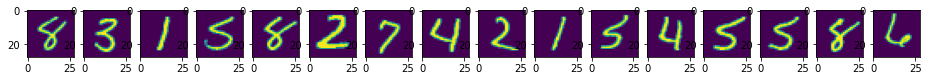

In [168]:
import json
import numpy as np
import boto3
import random
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

%matplotlib inline


def run_test(dataset, sagemaker_runtime, show_img=False, endpoint_name='sm-mnist-stage'):
    randidx = random.randint(0,9985)
    testdata = {"inputs": dataset.data.view(-1,1,28,28)[randidx:randidx+16].numpy().tolist()}
    response = sagemaker_runtime.invoke_endpoint(
                                EndpointName=endpoint_name, 
                                Body=bytes(json.dumps(testdata), 'utf-8'),
                                ContentType="application/json"
                                )

    result = np.argmax(json.loads(response['Body'].read().decode('utf-8')), axis=1)
    
    if show_img:
        fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))
        for i, splt in enumerate(axs):
            splt.imshow(testset.data[randidx+i].numpy())
    print(result)
    
region = boto3.Session().region_name
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)
endpoint_name='sm-mnist-stage'

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))])
testset = MNIST("./data", transform=mnist_transform, train=False, download=True)

run_test(testset, sagemaker_runtime, True)

In [171]:
for i in range(10000):
    run_test(testset, sagemaker_runtime)

[7 8 4 2 7 4 2 4 3 0 7 0 2 7 1 7]
[3 7 8 4 7 7 9 2 4 1 6 5 2 4 8 9]
[1 3 4 5 6 7 8 0 1 3 4 7 8 9 7 5]
[8 1 4 9 3 3 6 1 5 2 5 2 2 0 4 2]
[7 3 3 8 9 7 9 2 2 4 1 5 4 8 9 2]
[2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7]
[4 4 5 2 7 1 7 2 6 4 1 8 7 8 6 0]
[4 4 6 4 1 1 8 2 5 4 8 9 4 0 0 8]
[1 9 4 2 4 1 5 5 3 8 3 1 4 5 6 8]
[3 0 4 2 1 9 8 3 0 6 9 8 4 0 4 9]
[4 9 4 1 2 2 8 1 9 6 4 0 9 4 8 3]
[1 9 8 9 6 3 5 5 9 4 1 1 9 4 9 1]
[7 8 9 0 8 3 4 8 8 8 6 8 4 1 7 1]
[8 9 6 1 2 3 9 5 6 9 8 9 3 5 3 2]
[1 7 1 2 0 7 7 1 8 2 9 8 2 7 3 4]
[1 3 6 6 6 9 1 9 4 8 3 6 4 5 2 6]
[5 9 5 1 8 6 9 0 4 1 9 3 8 4 4 7]
[8 9 1 8 4 0 9 8 4 8 7 7 0 9 8 8]
[1 4 5 9 2 5 0 4 1 0 8 4 0 8 9 8]
[3 8 9 0 2 5 1 9 2 2 9 9 0 9 6 0]
[6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1]
[3 0 9 9 9 7 2 1 4 7 0 6 0 9 5 2]
[3 2 6 0 7 5 9 9 6 0 9 4 1 3 2 1]
[9 5 5 1 6 2 2 8 6 7 1 4 4 0 6 0]
[2 3 5 3 2 4 4 6 3 5 5 6 0 4 1 9]
[6 5 4 0 7 4 0 1 3 1 3 6 7 2 7 1]
[1 8 8 4 2 3 8 7 6 9 1 9 0 6 7 1]
[9 1 7 6 8 4 2 4 3 6 9 6 2 4 4 7]
[5 9 5 1 8 6 9 0 4 1 9 3 8 4 4 7]
[9 8 0 1 2 3 4